In [1]:
#imports
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

from utils.data import  DataLoader
from utils.metrics import calc_metrics
from utils.visulization import plot_confusion_matrix
#feature scaling
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

# load and split the data

In [2]:
dataset = "filtered"

if dataset == "filtered":
    filename='encoded/encoded_filtered_train_data_with_encoded_y.csv'
    test_filename='encoded/encoded_test_data_with_encoded_y.csv'


In [3]:
dl = DataLoader("./config.json")
dl.load_csv_data(filename=filename, test_filename=test_filename)
train_data = dl.get_data(include_target_column = True)
test_data = dl.get_test_data(include_target_column = True)
#train_data.info()
# split the data
X_train, y_train = dl.get_features_and_target(train_data)
X_test, y_test = dl.get_features_and_target(test_data)

loading test data from: C:\Users\dujem\PycharmProjects\bank-marketing\data\encoded/encoded_test_data_with_encoded_y.csv
loading data from: C:\Users\dujem\PycharmProjects\bank-marketing\data\encoded/encoded_filtered_train_data_with_encoded_y.csv
memory occupation before data type conversion: 13.82 MB
memory occupation after data type conversion: 7.04 MB
memory occupation before data type conversion: 1.6 MB
memory occupation after data type conversion: 820.71 KB


In [4]:
#TODO check how to use this
"""
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)
""";

# Random search hyperparameters

In [6]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)
{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

In [8]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid,
                               n_iter = 100, cv = 3, verbose=2, 
                               random_state=512, n_jobs = -1)
# Fit the random search model
#rf_random.fit(X_train, y_train) # this takes around 35 minutes

"""
results:

{'n_estimators': 2000,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 10,
 'bootstrap': True}
"""


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 15.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 33.9min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [9]:
rf_random.best_params_

{'n_estimators': 2000,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 10,
 'bootstrap': True}

# evaluating the best randomforest (with randomly found hyperparameters)

Auc:0.6136360613878767
Prec:0.6432748538011696
Rec:0.24390243902439024
Acc:0.9024034959941734
F1:0.3536977491961415
AP:0.2396833900489118


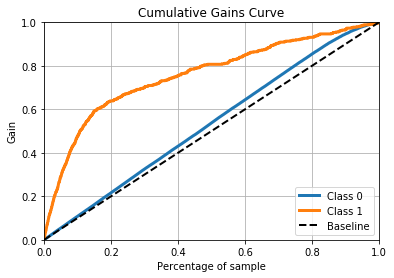

In [10]:
best_random = rf_random.best_estimator_
#prediction
y_pred = best_random.predict(X_test)
y_pred_proba = best_random.predict_proba(X_test)
calc_metrics(y_test, y_pred)
from utils.metrics import plot_cumulative_gain
plot_cumulative_gain(y_test, y_pred_proba)
"""
default classifier metric:
Auc:0.6110361199031837
Prec:0.3375959079283887
Rec:0.2926829268292683 <-
Acc:0.8596746783199806
F1:0.31353919239904987
AP:0.17625454045253935

Random RF metrics:
Auc:0.6136360613878767
Prec:0.6432748538011696 <-
Rec:0.24390243902439024
Acc:0.9024034959941734 <-
F1:0.3536977491961415
AP:0.2396833900489118

Grid search:
Auc:0.5875193741280131
Prec:0.7155172413793104
Rec:0.18403547671840353
Acc:0.9026462733673222
F1:0.29276895943562614
AP:0.2210226299362451
Cumulative gains izgleda dosta bolje od defaultnog
"""

# Comapre with default RF classifier

In [11]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train);

# Make predictions on test set and display evaluation results

In [12]:
#prediction
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)

In [13]:
calc_metrics(y_test, y_pred)
#plot_confusion_matrix(y_test, y_pred, title="Confusion matrix");

Auc:0.6110361199031837
Prec:0.3375959079283887
Rec:0.2926829268292683
Acc:0.8596746783199806
F1:0.31353919239904987
AP:0.17625454045253935


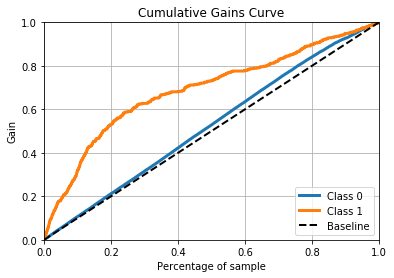

In [14]:
from utils.metrics import plot_cumulative_gain
plot_cumulative_gain(y_test, y_pred_proba)

# do the grid search now

In [16]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [3, 7, 10],
    'max_features': ['auto'],
    'min_samples_leaf': [4, 6],
    'min_samples_split': [10, 15, 20],
    'n_estimators': [2000]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [17]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:  4.7min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [18]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 3,
 'max_features': 'auto',
 'min_samples_leaf': 6,
 'min_samples_split': 15,
 'n_estimators': 2000}

In [19]:
"""
results:
{'bootstrap': True,
 'max_depth': 3,
 'max_features': 'auto',
 'min_samples_leaf': 6,
 'min_samples_split': 15,
 'n_estimators': 2000}
 """;

Auc:0.5875193741280131
Prec:0.7155172413793104
Rec:0.18403547671840353
Acc:0.9026462733673222
F1:0.29276895943562614
AP:0.2210226299362451


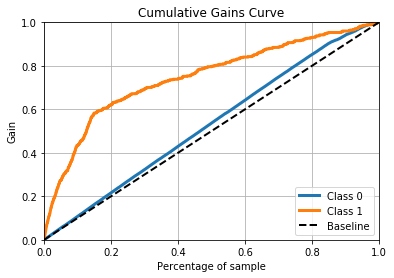

In [20]:
best_grid = grid_search.best_estimator_
#prediction
y_pred = best_grid.predict(X_test)
y_pred_proba = best_grid.predict_proba(X_test)
calc_metrics(y_test, y_pred)
from utils.metrics import plot_cumulative_gain
plot_cumulative_gain(y_test, y_pred_proba)

# manually create classifier

In [ ]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train);
#prediction
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)
calc_metrics(y_test, y_pred)
from utils.metrics import plot_cumulative_gain
plot_cumulative_gain(y_test, y_pred_proba)

# Finding important feature

In [ ]:
import pandas as pd
feature_imp = pd.Series(clf.feature_importances_,index=X_train.columns.values).sort_values(ascending=False)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Creating a bar plot
fig = plt.figure(figsize=(16,16))
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()